In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import scipy as sp
import seaborn as sn
from scipy.stats import gaussian_kde
import matplotlib.pylab as pl
%matplotlib inline

import os 
import hedfpy

from hedfpy.EDFOperator import EDFOperator
from hedfpy.HDFEyeOperator import HDFEyeOperator
from hedfpy.EyeSignalOperator import EyeSignalOperator, detect_saccade_from_data

sn.set(style="ticks")
import warnings
warnings.filterwarnings("ignore")

from PIL import Image

In [64]:
os.chdir('../../experiments/ST/')

# input file name
edf_file = 'data/tk_1_2017-10-17_17.10.44.edf'

low_pass_pupil_f, high_pass_pupil_f = 6.0, 0.01
alias = 'ST_1'

# initialize the hdfeyeoperator
ho = HDFEyeOperator(os.path.splitext(edf_file)[0] + '.h5')
# insert the edf file contents only when the h5 is not present.
if not os.path.isfile(os.path.splitext(edf_file)[0] + '.h5'):
    ho.add_edf_file(edf_file)
    ho.edf_message_data_to_hdf(alias = alias)
    ho.edf_gaze_data_to_hdf(alias = alias, pupil_hp = high_pass_pupil_f, pupil_lp = low_pass_pupil_f)


## load the data from the hdf5 file.

We'll print some of the outputs just to show you what's contained in the file

In [19]:
parameters = ho.read_session_data(alias, 'parameters')
parameters.head(10)

,distractor_deviation_angle,distractor_direction,distractor_x,distractor_y,fix_x,fix_y,fixation_time,max_eccentricity,n_trials,saccade_amplitude,saccade_direction,size_distractor_deg,size_fixation_deg,target_distractor_time,target_post_time,target_time,trial_nr
0,30.0,0.000000,0.000000,0.000000,0.000000,0.000000,30.00,12.0,240.0,7.0,0.000000,0.5,0.25,0.05,0.5,0.05,0.0
1,30.0,0.000000,163.260039,-175.068791,163.260039,-175.068791,0.75,12.0,240.0,7.0,2.391084,0.5,0.25,0.05,0.5,0.05,1.0
2,30.0,-0.523599,310.203089,13.903859,385.002778,-84.885200,0.75,12.0,240.0,7.0,1.184524,0.5,0.25,0.05,0.5,0.05,2.0
3,30.0,0.523599,184.126806,45.313748,145.939609,-72.567590,0.75,12.0,240.0,7.0,4.763868,0.5,0.25,0.05,0.5,0.05,3.0
4,30.0,0.523599,233.604542,-295.318082,333.234914,-221.642708,0.75,12.0,240.0,7.0,2.243054,0.5,0.25,0.05,0.5,0.05,4.0
5,30.0,-0.523599,123.617262,-106.042700,209.500706,-16.721338,0.75,12.0,240.0,7.0,5.739967,0.5,0.25,0.05,0.5,0.05,5.0
6,30.0,0.523599,152.409042,215.751164,43.821624,156.059922,0.75,12.0,240.0,7.0,5.518768,0.5,0.25,0.05,0.5,0.05,6.0
7,30.0,0.000000,262.828400,252.698186,262.828400,252.698186,0.75,12.0,240.0,7.0,1.155237,0.5,0.25,0.05,0.5,0.05,7.0
8,30.0,0.000000,38.242387,335.547718,38.242387,335.547718,0.75,12.0,240.0,7.0,5.065800,0.5,0.25,0.05,0.5,0.05,8.0
9,30.0,-0.523599,-10.182855,101.116666,-120.910629,156.737093,0.75,12.0,240.0,7.0,3.868891,0.5,0.25,0.05,0.5,0.05,9.0


In [38]:
trial_phases = ho.read_session_data(alias, 'trial_phases')
trial_phases.head(10)

,trial_phase_trial,trial_phase_EL_timestamp,trial_phase_index,trial_phase_exp_timestamp
0,0.0,1443157,1.0,53.2
1,0.0,1443205,2.0,53.3
2,0.0,1443256,3.0,53.3
3,1.0,1444555,1.0,54.6
4,1.0,1444610,2.0,54.7
5,1.0,1444660,3.0,54.7
6,2.0,1445960,1.0,56.0
7,2.0,1446010,2.0,56.1
8,2.0,1446073,3.0,56.1
9,3.0,1447360,1.0,57.4


In [39]:
trials = ho.read_session_data(alias, 'trials')
trials.head(10)

,trial_start_EL_timestamp,trial_start_index,trial_start_exp_timestamp,trial_end_EL_timestamp,trial_end_index,trial_end_exp_timestamp
0,1438596.0,0,48.7,1443791.0,0,53.8
1,1443791.0,1,53.8,1445208.0,1,55.3
2,1445208.0,2,55.3,1446609.0,2,56.7
3,1446609.0,3,56.7,1448013.0,3,58.1
4,1448013.0,4,58.1,1449411.0,4,59.5
5,1449411.0,5,59.5,1450783.0,5,60.8
6,1450783.0,6,60.8,1452184.0,6,62.2
7,1452184.0,7,62.2,1453596.0,7,63.6
8,1453597.0,8,63.7,1454979.0,8,65.0
9,1454980.0,9,65.0,1456379.0,9,66.4


In [56]:
screen_dims = ho.screen_dimensions_during_trial(alias=alias,trial_nr=0)

## First, dividing everything up into trials.

We combine information from the tables with the gaze data.

In [43]:
fixation_jump_times = np.array(trial_phases[trial_phases['trial_phase_index'] == 1]['trial_phase_EL_timestamp'])
trial_end_times = np.array(trials['trial_end_EL_timestamp'])

In [184]:
gaze_till_trial_end = [
    np.array(
        ho.signal_during_period(alias=alias, requested_eye='L', signal='gaze', time_period=(tp[0],tp[1]+300))
            )# * np.array([1,-1])
                       for tp in zip(fixation_jump_times, trial_end_times)]

In [201]:
# subtract the initial fixation position from all trials
gaze_till_trial_end_nofix = [gaze_till_trial_end[trial]-gaze_till_trial_end[trial][0] 
                             for trial in np.arange(1,len(parameters))]

# use the saccade direction to create rotation matrices for each trial
theta = np.angle(np.diff(parameters.fix_x) + 1j * -np.diff(parameters.fix_y))#np.array(parameters.saccade_direction)
rotation_matrices = np.array([[np.cos(theta), -np.sin(theta)],[np.sin(theta),np.cos(theta)]])

# now, we can rotate
gaze_till_trial_end_nofix_rotated = [
    np.dot(gaze_till_trial_end_nofix[trial], rotation_matrices[...,trial])
        for trial in np.arange(len(gaze_till_trial_end_nofix)-1)]

## plot some single trials to see what's up.

With their fixation mark position and target position

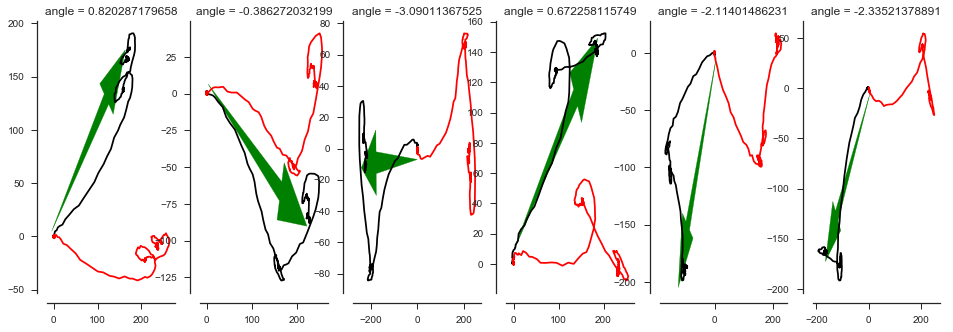

In [227]:
# which trials to plot
which_trials = [0,1,2,3,4,5]
f = pl.figure(figsize = (16,5))
for i, trial in enumerate(which_trials):
    s = f.add_subplot(1,len(which_trials),i+1)
    pl.plot(gaze_till_trial_end_nofix[trial][:,0],gaze_till_trial_end_nofix[trial][:,1], 'k')
    pl.plot(gaze_till_trial_end_nofix_rotated[trial][:,0],gaze_till_trial_end_nofix_rotated[trial][:,1], 'r')
#     pl.plot([0,np.diff(parameters.fix_x)[trial]], [0,-np.diff(parameters.fix_y)[trial]], 'g')
    s.arrow(0,0,np.diff(parameters.fix_x)[trial],-np.diff(parameters.fix_y)[trial], color='g', width=14, length_includes_head=True)
    s.set_title('angle = ' + str(theta[trial]))
    sn.despine(ax=s, offset=10)

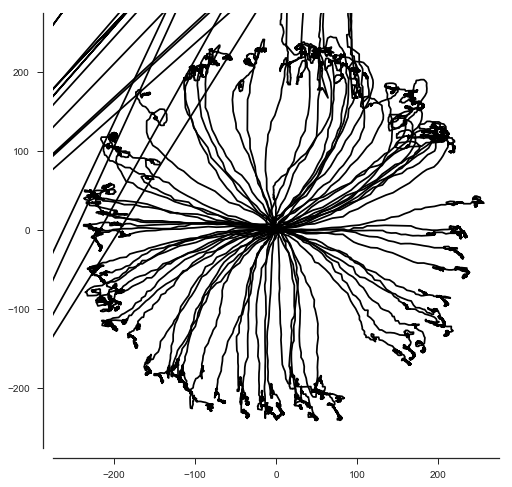

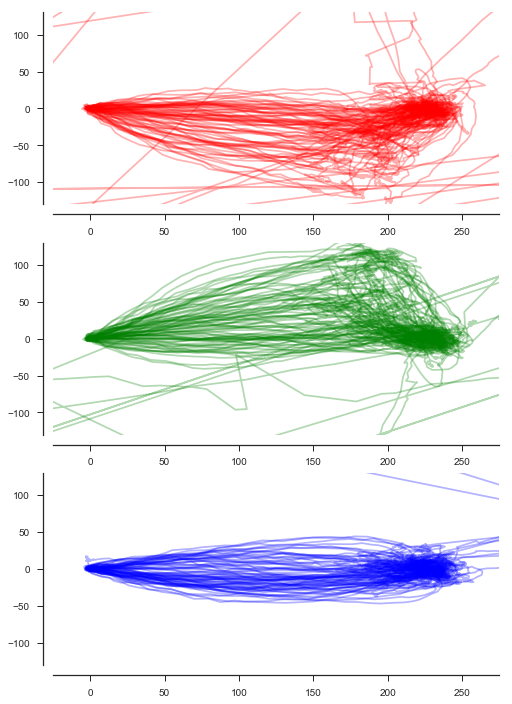

In [221]:
# which trials to plot

f = pl.figure(figsize = (8,8))
s = f.add_subplot(111)
for i, trial in enumerate(which_trials):
    pl.plot(gaze_till_trial_end_nofix[trial][:,0],gaze_till_trial_end_nofix[trial][:,1], 'k')
s.set_xlim([-275,275])
s.set_ylim([-275,275])
sn.despine(ax=s, offset=10)


f = pl.figure(figsize = (8,12))
for i, sign_distractor in enumerate([-1,1,0]):
    which_trials = np.arange(len(gaze_till_trial_end_nofix_rotated))[np.sign(parameters.distractor_direction)[1:-1] == sign_distractor]
    s = f.add_subplot(3,1,i+1)
    for wt in which_trials:
        pl.plot(gaze_till_trial_end_nofix_rotated[wt][:,0],
                gaze_till_trial_end_nofix_rotated[wt][:,1], ['r','g','b'][i], alpha=0.3)
    s.set_xlim([-25,275])
    s.set_ylim([-130,130])
    sn.despine(ax=s, offset=10)



In [230]:
for xy_data in gaze_till_trial_end_nofix_rotated:
    saccades = detect_saccade_from_data(xy_data=xy_data, 
                                        l=6, 
                                        minimum_saccade_duration=0.0025)
#     print(saccades)

In [232]:
ho.read_session_data??